In [1]:
%load_ext autoreload
%autoreload 2

# Introduction and Objective
## Splitting the data into train, val, and test

Note! the Isfahan Uni of Med Science data (dataset_1) are excluded from this round of analysis. We include that 
dataset when we have their metadata avilable so that we can split them by stratification on the subjects' age.

In [2]:
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from datetime import datetime

In [3]:
from cvmt.utils import nested_dict_to_easydict
from cvmt.ml.utils import split_filenames
from cvmt.ml.utils import stratify_dataset_4
from cvmt.data.prep import merge_metadata_tables

/home/samehr/Desktop/cephal/cvmt/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-12 17:42:01,016	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', None)

In [5]:
os.chdir('../../')

# load parameters

In [6]:
with open("configs/params.yaml") as f:
    params = yaml.safe_load(f)
    params = nested_dict_to_easydict(params)

In [7]:
print(params)

{'RAW_DATA_DIRECTORY': 'data/raw', 'INTERMEDIATE_DATA_DIRECTORY': 'data/intermediate', 'PRIMARY_DATA_DIRECTORY': 'data/primary', 'ARTIFACTS_DATA_DIRECTORY': 'artifacts', 'RAW': {'DATASET_1': {'RAW_ZIP_FILE_NAME': 'radiography-20221212T190109Z-001.zip', 'RAW_ZIP_NEW_ANNOT_FILE_NAME': 'label_edited-20230122T143005Z-001.zip', 'INTERMEDIATE_DIR_NAME': 'dataset_1', 'UNWANTED_JSON_FIELDS': ['imageData']}, 'DATASET_3': {'RAW_RAR_FILE_NAME': 'RawImage.rar', 'RAW_DIR_NAME_TEMP': 'dataset_3_bmp', 'RAW_DIR_NAME': 'dataset_3_raw_data'}}, 'INTERM': {'UNWANTED_JSON_FIELDS': ['imageData', 'imagePath'], 'N_PROCESSES': 3, 'DATASET_1': {'DIR_NAME': 'dataset_1_interm_data-20230513T084705Z-001', 'IMG_DIR_NAME': ['image'], 'V_LANDMARKS_DIR_NAME': ['label'], 'F_LANDMARKS_DIR_NAME': None}, 'DATASET_2': {'DIR_NAME': 'dataset_2_interm_data-20230304T160421Z-001', 'IMG_DIR_NAME': ['image'], 'V_LANDMARKS_DIR_NAME': ['label'], 'F_LANDMARKS_DIR_NAME': None}, 'DATASET_3': {'DIR_NAME': 'dataset_3_interm_data-20230304

# recreate the metadata table from individual dataset's metadata

Uncomment the line below with caution!

In [8]:
# merge_metadata_tables(params)

# load the metadata table and perform the splitting

In [9]:
metadata_table = pd.read_hdf(
    os.path.join(params.PRIMARY_DATA_DIRECTORY, params.TRAIN.METADATA_TABLE_NAME),
)

In [10]:
metadata_table.shape

(844, 18)

In [11]:
metadata_table.head(5)

,valid_v_annots,valid_f_annots,edges_present,harmonized_id,source_image_filename,dataset,dev_set,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols,f_annots_rows,f_annots_cols,age,grouping_factor,split
0,True,False,True,e7a3e0bb80db6d289234,45.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,NaN,dataset_1,train
1,True,False,True,4cee5b9bf553bb7bef43,92.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,NaN,dataset_1,train
2,True,False,True,c8a75bb00e9339608268,43.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,NaN,dataset_1,val
3,True,False,True,0d1d0d042edf35bd316c,7.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,NaN,dataset_1,val
4,True,False,True,5a3b5c5837f813eca6ad,121.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,NaN,dataset_1,train


In [12]:
metadata_table.groupby('split')['dataset'].describe()

,count,unique,top,freq
split,,,,
test,163,4,dataset_3,76
train,471,4,dataset_3,224
undefined,55,4,dataset_3,26
val,155,4,dataset_3,74


In [13]:
selected_samples = metadata_table.loc[
    (metadata_table['dataset'].isin(params.TRAIN.DATASETS_TO_INCLUDE)) & (
        metadata_table['valid_v_annots'] == True
    ),
    ['harmonized_id', 'dataset', 'source_image_filename', 'split', 'grouping_factor']
]

In [14]:
selected_samples.shape

(789, 5)

In [15]:
selected_samples.describe()

,harmonized_id,dataset,source_image_filename,split,grouping_factor
count,789,789,789,789,789
unique,789,4,656,3,8
top,e7a3e0bb80db6d289234,dataset_3,45.jpg,train,dataset_3
freq,1,374,2,471,374


In [16]:
metadata_table.groupby('split')['dataset'].describe()

,count,unique,top,freq
split,,,,
test,163,4,dataset_3,76
train,471,4,dataset_3,224
undefined,55,4,dataset_3,26
val,155,4,dataset_3,74


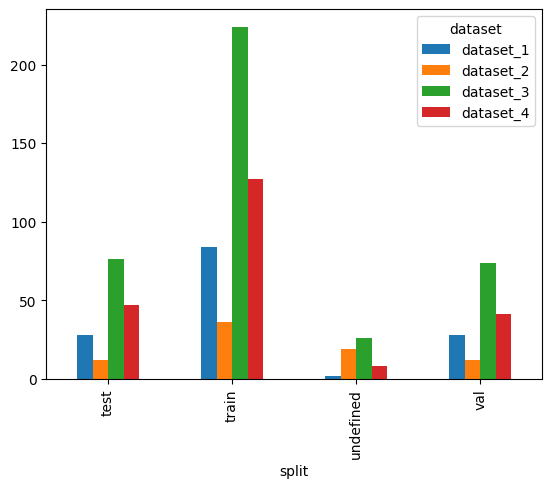

In [17]:
grouped_split_dataset = metadata_table.groupby(['split','dataset']).size().unstack().plot(kind='bar', legend=True) # apply(lambda x: len(x))

# Export the malformed v_annots files

In [18]:
malformed = metadata_table.loc[metadata_table['valid_v_annots']==False, ['dataset', 'source_image_filename']].reset_index(drop=True)

In [19]:
today_str = datetime.today().strftime('%Y-%m-%d')
malformed.to_csv(f"notebooks/ml/v_annots_malformed_{today_str}.csv", sep=';')